In [1]:
from Annotation_helper import *
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

Sets correct values for generated figures:

In [2]:
#Set all settings for the resulting figures

import seaborn as sns
sns.set()

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Helper functions

In [3]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Loading data
Set paths to files:

In [4]:
data_folder = "../../Data"
structured_data_folder = data_folder + "/structured_data"
text_path = data_folder + "/text"
data_path = structured_data_folder + "/test.csv"
dist_folder = structured_data_folder + "/Distances"
figure_folder = "../Figures/Results/Embeddings"
model_folder = "../Models/Embeddings"
matches = pd.read_csv(structured_data_folder + "/Matches/Bas.csv", index_col=0)
figure_folder = "../Figures/Results/Classic/"
error_folder = structured_data_folder + "/Errors/"

Load transaction and permission datasets:

In [5]:
transactions = load_transactions(structured_data_folder + "\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions(structured_data_folder + "\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

E:\UvA\Scriptie\Thesis_code\Annotation\Annotation_helper.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^a-zA-Z ]', '')


Load distances between datasets from multiple files and merge them into one dataframe:

In [6]:
distances = pd.read_csv(dist_folder + "/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"{dist_folder}/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])
distances.reset_index(inplace=True)

Split the data into a test and training set:

In [7]:
all_data = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
all_data["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index
        all_data.loc[indx, "Match"] = 1
data = all_data.iloc[:, :-1]
y = all_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

<ipython-input-7-9a3b798d26a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["Match"] = 0
C:\Users\basvd\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [8]:
print(f"Amount of matches in training set: {y_train.sum()}")
print(f"Amount of matches in test set: {y_test.sum()}")

Amount of matches in training set: 72
Amount of matches in test set: 38


In [9]:
matches

,Annotator,transaction_indx,permission_indx
0,Bas,None,0
1,Bas,None,1
2,Bas,None,2
3,Bas,None,3
4,Bas,None,4
...,...,...,...
727,Bas,5870,689
728,Bas,None,690
729,Bas,None,691
730,Bas,None,692


In [10]:
# sample1 = all_data[all_data["Match"] == 0].sample(61)
# sample2 = all_data[all_data["Match"] == 1].sample(60)

# sample = pd.concat([sample1, sample2])
# y = sample["Match"]

In [11]:
def plot_decision_boundary(X, y, model, model_name="Default_model", ax_labels=('x', 'y'), colors = ("b", "r"), labels=("non-matches", "matches")):
    clf = model.fit(X, y)

    fig, ax = plt.subplots()
    # title for the plots
    title = (f'Decision surface of {model_name}')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    for i in range(0, 2):
        mask = (y == i)
        tX = X[mask]
        ty = y[mask]
        X0, X1 = tX[:, 0], tX[:, 1]
        ax.scatter(X0, X1, c=colors[i], s=20, edgecolors='k', label=labels[i])
    ax.set_ylabel(f'{ax_labels[1]} similarity')
    ax.set_xlabel(f'{ax_labels[0]} similarity')

    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.savefig(figure_folder + f"Decision_boundary_{model_name}.png", bbox_inches="tight")
    plt.show()

In [12]:
# plot_decision_boundary(X, y, make_pipeline(StandardScaler(), LogisticRegressionCV()), "Logistic_regression", ("slave name", "owner first name"))

In [13]:
# plot_decision_boundary(X, y, make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=30, random_state=0)), "ADAboost", ("slave name", "owner first name"))

In [14]:
# plot_decision_boundary(X, y, make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False)), "Neural Network", ("slave name", "owner first name"))

In [15]:
# plot_decision_boundary(X, y, KNeighborsClassifier(n_neighbors=1), "KNN", ("slave name", "owner first name"))

In [16]:
Classifiers = dict()

# Blocking
Perform blocking to reduce the size of the data

In [17]:
print(f"{X_train.shape[0]} rows before blocking")
# mask = (X_train["SlaafNaamNieuw"] > 0.3) & (X_train["SlaafGender"] > 0.1) & (X_train["BezitterAchternaam"] > 0.1) & (X_train["BezitterVoornaam"] > 0.1)
mask = (X_train["SlaafNaamNieuw"] > 0.6)

X_train = X_train[mask]
y_train = y_train[mask]
print(f"{X_train.shape[0]} rows after blocking")

X_test_pd = X_test
y_test_pd = y_test

X_train = X_train.iloc[:,3:].to_numpy().astype(float)
y_train = y_train.to_numpy().astype(float)
X_test = X_test.iloc[:,3:].to_numpy().astype(float)
y_test = y_test.to_numpy().astype(float)

3486898 rows before blocking
55856 rows after blocking


# Rule based

In [18]:
class Rule_based_classifier():
    def __init__(self, alg):
        self.alg = alg
        
    def predict_proba(self, X_test):
        pred = self.alg(X_test)
        return pred
    
    def predict(self, X_test, thresh):
        pred = self.alg(X_test)
        return (pred >= thresh).astype(float)

## Exact match
The exact match algorithm determines the likelyhood of a match using the amount of features that match exactly between the two datasets.

In [19]:
def exact_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x == 1.).sum())
    return np.array(pred)/X_test.shape[1]

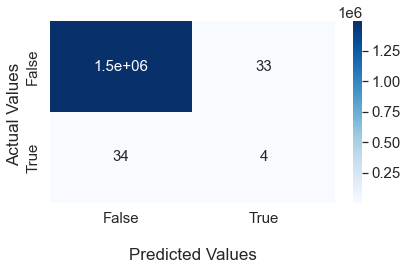

recall score:  0.10526315789473684
precision score:  0.10810810810810811
f1 score:  0.10666666666666667


In [20]:
EM = Rule_based_classifier(exact_match)
pred = EM.predict(X_test, 0.56)
evaluate_prediction(pred, y_test, model_name = "Exact Match", figure_folder=figure_folder)
Classifiers["Exact Match"] = EM

# Fuzzy match
The fuzzy match algorithm determines the likelyhood of a match using the amount of features that have a similarity above a given threshold between the two datasets

In [21]:
def fuzzy_match(X_test):
    pred = []
    for x in X_test:
        pred.append((x > 0.8).sum())
    return np.array(pred)/X_test.shape[1]

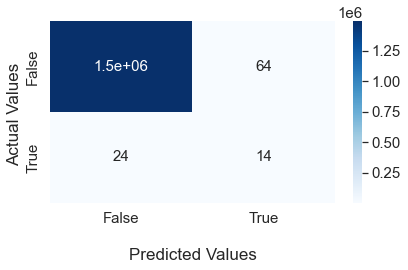

recall score:  0.3684210526315789
precision score:  0.1794871794871795
f1 score:  0.2413793103448276


In [22]:
FM = Rule_based_classifier(fuzzy_match)
pred = FM.predict(X_test, 0.6)
evaluate_prediction(pred, y_test, model_name = "Fuzzy Match", figure_folder=figure_folder)
Classifiers["Fuzzy Match"] = FM

# All 0
The all 0 method always predicts that 2 features are not a match

In [23]:
pred = np.zeros(len(y_test))
pred

array([0., 0., 0., ..., 0., 0., 0.])

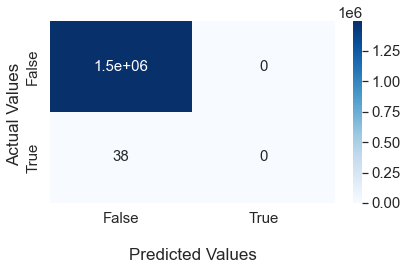

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


In [24]:
evaluate_prediction(pred, y_test, model_name="All 0")

# K nearest neighbors

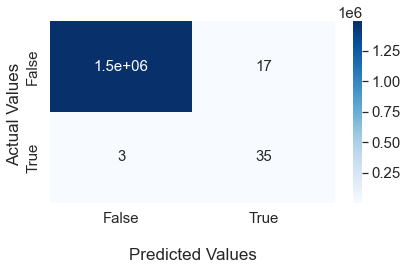

recall score:  0.9210526315789473
precision score:  0.6730769230769231
f1 score:  0.7777777777777778


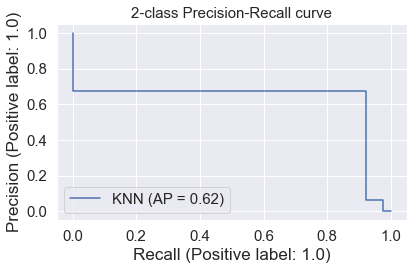

In [25]:
from sklearn.neighbors import KNeighborsClassifier
KNNClf = fit_and_test_classifier(KNeighborsClassifier(n_neighbors=2), X_train, X_test, y_train, y_test, model_name="KNN", figure_folder=figure_folder)

Classifiers["KNeigbors classifier"] = KNNClf

# ADA boost

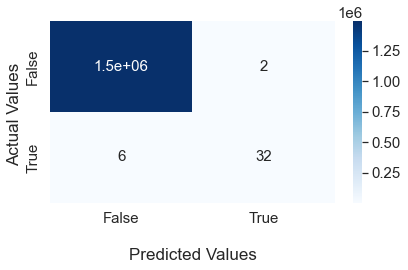

recall score:  0.8421052631578947
precision score:  0.9411764705882353
f1 score:  0.8888888888888888


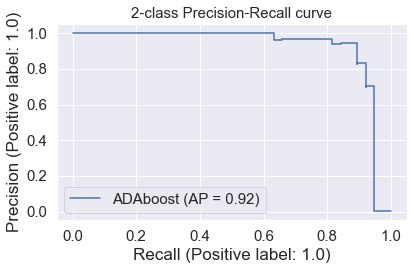

In [26]:
est = make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=30, random_state=0))
ADAboost = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="ADAboost", figure_folder=figure_folder)

Classifiers["ADAboost"] = ADAboost

# Logistic regression

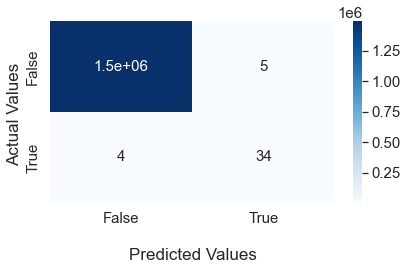

recall score:  0.8947368421052632
precision score:  0.8717948717948718
f1 score:  0.8831168831168831


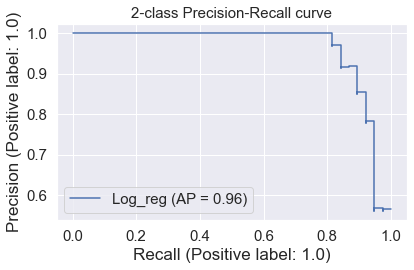

In [27]:
est = make_pipeline(StandardScaler(), LogisticRegressionCV(scoring='f1', penalty='l2'))
LRClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="Log_reg", figure_folder=figure_folder)

Classifiers["Logistic Regression"] = LRClf

In [28]:
LRClf.steps[1][1].coef_

array([[-0.15473852,  1.97297755,  1.24320492,  1.0538318 ,  0.14918191,
         1.41241171,  0.19086127,  0.39364868, -0.35987505]])

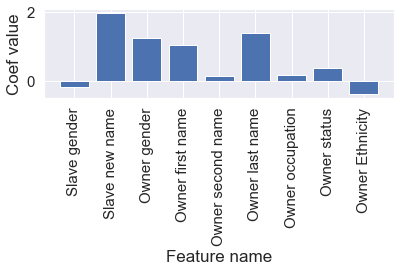

In [29]:
fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
langs = data.columns
langs = ["Slave gender", "Slave new name", "Owner gender", "Owner first name", "Owner second name", "Owner last name", "Owner occupation", "Owner status", "Owner Ethnicity"]
students = LRClf.steps[1][1].coef_[0]
plt.bar(langs,students)
plt.xticks(rotation = 90)
plt.xlabel("Feature name")
plt.ylabel("Coef value")
plt.tight_layout()
plt.savefig(figure_folder + "Coefs.jpg", bbox_inches="tight")
plt.show()

# Naive Bayes

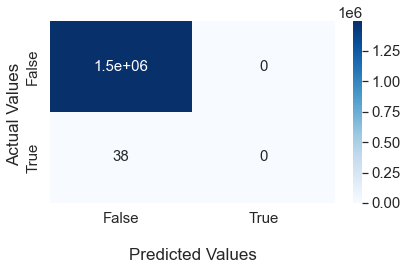

recall score:  0.0


C:\Users\basvd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:  0.0
f1 score:  0.0


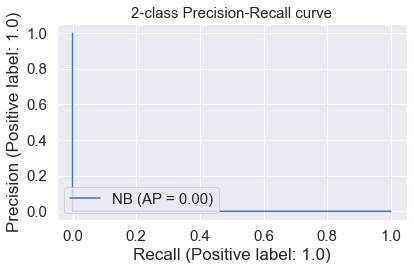

In [30]:
est = make_pipeline(Normalizer(), MultinomialNB())
NBClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="NB", figure_folder=figure_folder)

Classifiers["Naive Bayes"] = NBClf

# Neural Network

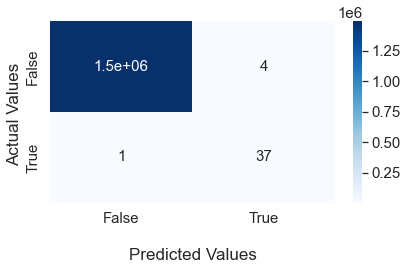

recall score:  0.9736842105263158
precision score:  0.9024390243902439
f1 score:  0.9367088607594938


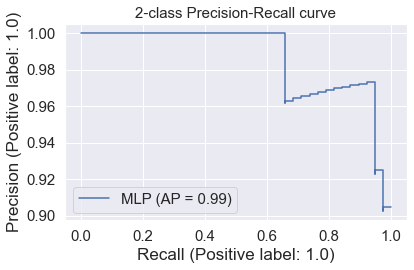

In [31]:
est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(30, 30), learning_rate='adaptive', random_state=1, verbose=False))

NNClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
Classifiers["Neural network"] = NNClf

# Linear Support Vector Classifier

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


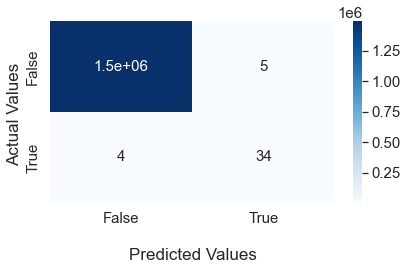

recall score:  0.8947368421052632
precision score:  0.8717948717948718
f1 score:  0.8831168831168831


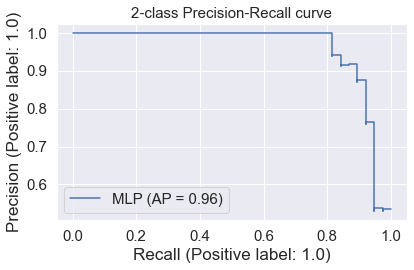

In [32]:
est = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
LSVC = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
Classifiers["Linear SVC"] = LSVC

In [33]:
def add_prefix_to_columns(df, prefix):
    # Adds a given prefix to all column names
    cols = df.columns
    df.columns = [prefix + c for c in cols]
    return df

def get_mistakes(y_pred, y_true, X_array, X_df, t, p):
    # Filters out errors in predictions and saves them as csv files
    p.set_index("Entry-ID")
    mist_indx = np.invert(y_true == y_pred)
    mist_dist = X_df[mist_indx]
    print(mist_dist.shape)
    mist_p = p.loc[mist_dist['permission_indx'], :]
    mist_t = t.loc[mist_dist['transaction_indx'], :]
    vt = add_prefix_to_columns(mist_t, "transaction_")
    vp = add_prefix_to_columns(mist_p, 'permission_')
    vals = np.concatenate((vt, vp), axis=1)
    mist_data = pd.DataFrame(data=vals, columns=list(vt) + list(vp))
    mist_data["Match"] = y_test[mist_indx]
    mist_data[mist_data["Match"] == 0].to_csv(error_folder + "False_Positives.csv")
    mist_data[mist_data["Match"] == 1].to_csv(error_folder + "False_Negatives.csv")
    return mist_data

pred = LRClf.predict(X_test)
mist = get_mistakes(pred, y_test, X_test, X_test_pd, transactions, permissions)

(9, 12)


In [34]:
from sklearn.metrics import plot_precision_recall_curve

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


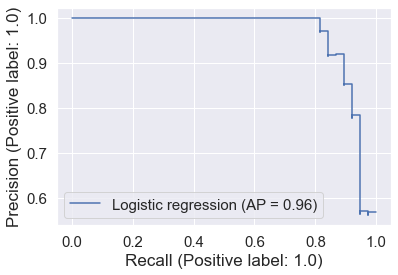

In [35]:
plot_precision_recall_curve(LRClf, X_test, y_test, name="Logistic regression", ax=plt.gca())

C:\Users\basvd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\basvd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

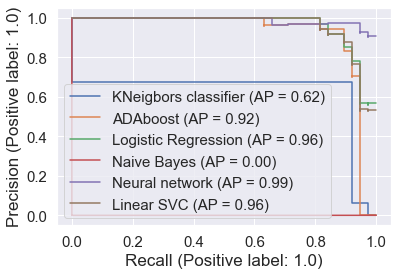

In [36]:
for clf_name in Classifiers:
    clf = Classifiers[clf_name]
    try:
        plot_precision_recall_curve(clf, X_test, y_test, name=clf_name, ax=plt.gca())
    except:
        pass
    
plt.show()

In [37]:
# def make_layers(layer_size, n_layers):
#     res = []
#     for ls in layer_size:
#         res += [ls for i in range(0, n_layers)]
#     return res
        
# layers = make_layers([100, 50, 20], 10)

In [38]:
# est = make_pipeline(StandardScaler(), MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=layers, learning_rate='adaptive', random_state=1, verbose=False))

# NNClf = fit_and_test_classifier(est, X_train, X_test, y_train, y_test, model_name="MLP", figure_folder=figure_folder)
# Classifiers["Neural network"] = NNClf

In [39]:
# for name in Classifiers:
#     model = Classifiers[name]
# #     print("name:", name)
#     # predict probabilities
#     lr_probs = model.predict_proba(X_test)
#     # keep probabilities for the positive outcome only
# #     print("lr_probs", lr_probs)
#     if type(lr_probs[0]) == np.ndarray:
#         lr_probs = lr_probs[:, 1]
#     # calculate scores
#     lr_auc = roc_auc_score(y_test, lr_probs)
#     # summarize scores
#     print(name + ': ROC AUC=%.3f' % (lr_auc))
#     # calculate roc curves
#     lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
#     # plot the roc curve for the model
#     plt.plot(lr_fpr, lr_tpr, marker='.', label=name)
    
# ns_probs = [0 for _ in range(len(y_test))]
# ns_auc = roc_auc_score(y_test, ns_probs)
# ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# print('No Skill: ROC AUC=%.3f' % (ns_auc))

# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()